# Задание 2.
Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил  с 2022-01-28 по 2022-02-03 включительно. Для эксперимента были задействованы 0 и 1 группы.  
В 1 группе был использован новый алгоритм рекомендации постов, 0 группа использовалась в качестве контроля. 
Основная гипотеза заключается в том, что новый алгоритм в 1 группе приведет к увеличению CTR. 
Ваша задача — проанализировать данные АB-теста.

### Задачи:
1. Выбрать метод анализа и сравнить CTR в двух группах.
2. Провести контрольную проверку, что новый алгоритм не привел к тому, что сократилось число просмотров у пользователей. Типичная ситуация в АB-тестах — вырастили число лайков, но уменьшили число просмотров.
3. Написать рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей.

### 1. Подготовка к работе

In [1]:
# Подгружаем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandahouse
from scipy import stats

### 2. Загрузка данных

In [2]:
# Подключение к БД
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220120'
}

# Запрос к БД
query = '''
SELECT user_id,
       exp_group,
       countIf(user_id, action = 'like' ) as like,
       countIf(user_id, action = 'view' ) as view,
       like/view as ctr
FROM simulator_20220120.feed_actions
WHERE (toDate(time) >= '2022-01-28' AND toDate(time) <= '2022-02-03' 
AND exp_group in [0,1])
GROUP BY user_id, exp_group
'''

# Создание датафрейма
df = pandahouse.read_clickhouse(query, connection=connection)

In [3]:
# Проверка df
df

,user_id,exp_group,like,view,ctr
0,26117,1,5,21,0.238095
1,138232,1,5,29,0.172414
2,49204,1,10,62,0.161290
3,49286,1,7,19,0.368421
4,145957,1,54,129,0.418605
...,...,...,...,...,...
25994,3681,0,6,28,0.214286
25995,110956,1,12,63,0.190476
25996,132567,1,18,66,0.272727
25997,30872,1,25,82,0.304878


### 3. Анализ данных

Визуализируем распределение CTR в группах 0 и 1

mean_ctr: 0.22195492956578466


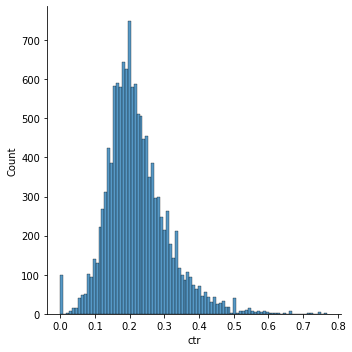

In [4]:
# Распределение экспериментальной группы 0
sns.displot(df[df.exp_group == 0].ctr, kde = False);
print('mean_ctr:', df[df.exp_group == 0].ctr.mean())

mean_ctr: 0.23648646948093363


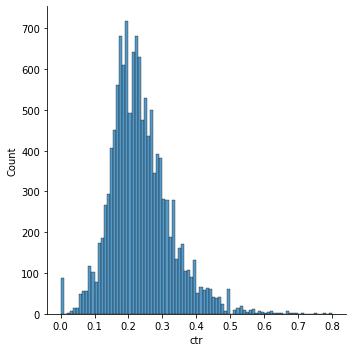

In [5]:
# Распределение экспериментальной группы 1
sns.displot(df[df.exp_group == 1].ctr, kde = False);
print('mean_ctr:', df[df.exp_group == 1].ctr.mean())

При визуальном сравнении 2х распределений можно отметить общий схожий нормальный характер распределений, однако в диапазаоне 0.18-0.25 на вершине распределения видны некоторые видимые различия. В целом критичных визуальных различий в распределениях между экспериментальными группами не выявлено.

**Задача 1. Выбрать метод анализа и сравнить CTR в двух группах.**

***Гипотеза:*** Выдвинем гипотезу, что при использовании нового алгоритма в экспериментальной группе 1, CTR увеличится. \
***Нулевая гипотеза:*** средние значения CTR в контрольной и экспериментальной группaх равны. \
***Альтернативная гипотеза:*** средние значения CTR в экспериментальной группе выше значений в контрольной. \
***Пороговое значение p-value:*** 0.05

**Метод 1.** Использование пользовательского CTR

In [6]:
# Сравнение непараметричиским U-критерием Манна — Уитни
stats.mannwhitneyu(df[df.exp_group == 0].ctr, df[df.exp_group == 1].ctr, alternative='less')

MannwhitneyuResult(statistic=75455843.5, pvalue=9.550851479424271e-51)

In [7]:
# Сравнение параметричиским T-тестом
stats.ttest_ind(df[df.exp_group == 0].ctr, df[df.exp_group == 1].ctr, equal_var = False, alternative='less')

Ttest_indResult(statistic=-13.161168998357258, pvalue=9.816547547340797e-40)

Оба критерия однозначно показывают p-value значительно < 0.05, что позволяет нам отменить нулевую гипетезу и принять альтернативную гипетезу. \
**Вывод:** средние значения CTR в экпериментальной группе выше значений в контрольной

**Метод 2.** Использование сглаженного CTR, метод Smoothed

In [8]:
def get_smoothed_ctr(user_likes, user_views, global_ctr, alpha = 5):
    """
    Функция принимает на вход ctr юзера, возвращает сглаженный ctr
    --------------------
    Параметры:
    user_likes - лайки пользователя
    user_views - просмотры пользователя
    global_ctr - like/view для всех пользователей
    alpha - коэффициент сглаживания

    Функция возвращает: 
    smooth_ctr - значение сглаженного CTR
    """
    smooth_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smooth_ctr

In [9]:
global_ctr = df.like.sum() / df.view.sum()
global_ctr

0.22149774745073217

In [10]:
# Добавим колонку smoothed_ctr
df['smoothed_ctr'] = df.apply(lambda x: get_smoothed_ctr(x['like'], x['view'], global_ctr, 5), axis = 1)
df.sort_values('view')

,user_id,exp_group,like,view,ctr,smoothed_ctr
7486,138172,1,0,1,0.000000,0.184581
23644,139520,1,0,1,0.000000,0.184581
22598,130204,1,0,1,0.000000,0.184581
24357,112433,0,0,1,0.000000,0.184581
22718,138035,1,0,2,0.000000,0.158213
...,...,...,...,...,...,...
12221,38820,0,50,303,0.165017,0.165933
22897,39976,0,41,312,0.131410,0.132831
22216,51499,1,48,339,0.141593,0.142754
14883,145951,1,64,362,0.176796,0.177405


Посмотрев на сглаженную метрику CTR можно увидеть как вносится штраф на пользователей с малым количеством просмотров

Визуализируем распределения сглаженного CTR, полученные используя метод Smoothed

mean_ctr: 0.2209584855620722


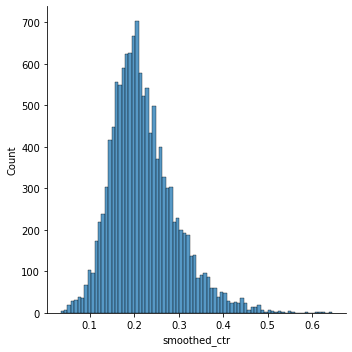

In [11]:
# Получившийся smoothed_ctr для экспериментальной группы 0
sns.displot(df[df.exp_group == 0].smoothed_ctr, kde = False);
print('mean_ctr:', df[df.exp_group == 0].smoothed_ctr.mean())

mean_ctr: 0.234139241899461


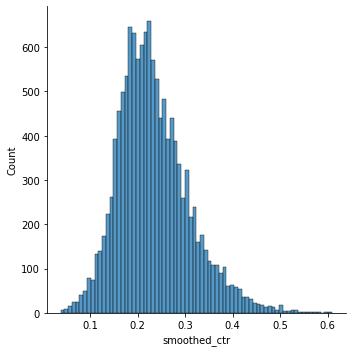

In [12]:
# Получившийся smoothed_ctr для экспериментальной группы 1
sns.displot(df[df.exp_group == 1].smoothed_ctr, kde = False);
print('mean_ctr:', df[df.exp_group == 1].smoothed_ctr.mean())

In [13]:
# Сравнение непараметричиским U-критерием Манна — Уитни
stats.mannwhitneyu(df[df.exp_group == 0].smoothed_ctr, 
                   df[df.exp_group == 1].smoothed_ctr, alternative='less')

MannwhitneyuResult(statistic=75190942.5, pvalue=1.227686809848908e-53)

In [14]:
# Сравнение параметричиским T-тестом
stats.ttest_ind(df[df.exp_group == 0].smoothed_ctr, 
                df[df.exp_group == 1].smoothed_ctr, equal_var = False, alternative='less')

Ttest_indResult(statistic=-14.27852163637724, pvalue=2.225628818760266e-46)

Используя метод Smoothed для метрики CTR, мы внесли внесли штрафы для пользователей с малым количеством просмотров. Теперь CTR пользователей с малым и большим количеством просмотром стал более сбалансированный. \
Оба критерия однозначно показывают p-value значительно < 0.05, что позволяет нам отменить нулевую гипетезу и принять альтернативную гипетезу. \
**Вывод:** средние значения CTR в экпериментальной группе выше значений в контрольной

**Метод 3.** Использование общего CTR, метод bootstrap

In [15]:
def get_global_ctr(df, exp_group, count_tests = 1000):
    
    """
    функция get_global_ctr использует метод 
    bootstrap для нахождения глобальных CTR
    --------------------
    Параметры:
    df - датафрейм
    exp_group - экспериментальная группа в датафрейме
    count_tests - число проведенных имитаций A/B тестов

    Функция возвращает: 
    pd.Series(glob_ctr_list) - Series из общих CTR
    """
    
    glob_ctr_list = []
    for _ in range(count_tests):
        sample_data = df[df.exp_group == exp_group].sample(frac=0.5, replace=True)
        glob_ctr = sample_data.like.sum() / sample_data.view.sum()
        glob_ctr_list.append(glob_ctr)
    return pd.Series(glob_ctr_list)

In [16]:
# Сохраним полученные bootstrap-распределения CTR в переменные
glob_ctr_group_0 = get_global_ctr(df, 0)
glob_ctr_group_1 = get_global_ctr(df, 1)

Визуализируем распределения общего CTR, полученные используя метод bootstrap

0.21159720815380192 0.21312935433192917 0.21159720815380192


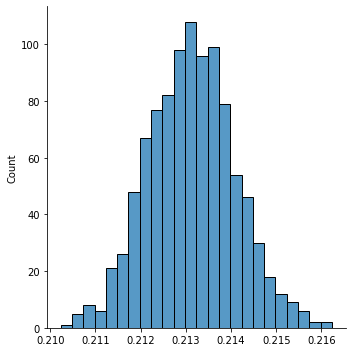

In [17]:
# Распределение группы 0
sns.displot(glob_ctr_group_0, kde = False);
print(glob_ctr_group_0.quantile(0.05),
      glob_ctr_group_0.mean(),
      glob_ctr_group_0.quantile(0.05))

0.22823722554192843 0.22991403103033514 0.22823722554192843


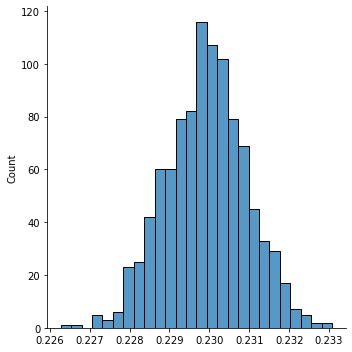

In [18]:
# Распределение группы 1
sns.displot(glob_ctr_group_1, kde = False);
print(glob_ctr_group_1.quantile(0.05),
      glob_ctr_group_1.mean(),
      glob_ctr_group_1.quantile(0.05))

In [19]:
# Сравнение непараметричиским U-критерием Манна — Уитни
stats.mannwhitneyu(glob_ctr_group_0, glob_ctr_group_1, alternative='less')

MannwhitneyuResult(statistic=0.0, pvalue=0.0)

In [20]:
# Сравнение параметричиским T-тестом
stats.ttest_ind(glob_ctr_group_0, glob_ctr_group_1, equal_var = False, alternative='less')

Ttest_indResult(statistic=-380.182540370158, pvalue=0.0)

In [21]:
# Выборки не пересекаются
print(glob_ctr_group_0.min(), glob_ctr_group_0.max())
print(glob_ctr_group_1.min(), glob_ctr_group_1.max())

0.21023123518042522 0.21623526887652675
0.22627592004018882 0.23307510347403432


Используя метод bootstrap мы получили распределения общего CTR для групп 0 и 1. Еще на этапе визуализации можно было бы с достаточной уверенностью утверждать, что средние CTR в группе 1 выше значений в группе 0. p-value равное 0 в обоих критериях только подтверждает это, что позволяет нам отменить нулевую гипетезу и принять альтернативную гипетезу..\
**Вывод:** средние значения CTR в экпериментальной группе выше значений в контрольной

**Задача 2. Провести контрольную проверку, что новый алгоритм не привел к тому, что сократилось число просмотров у пользователей. Типичная ситуация в АB-тестах — вырастили число лайков, но уменьшили число просмотров.**

61.297914903439256


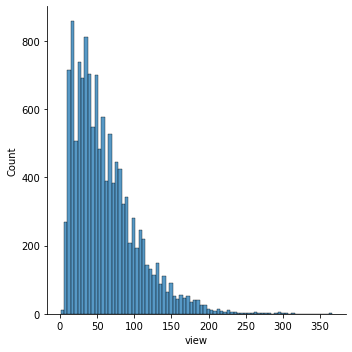

In [22]:
# Распределение просмотров в группе 0
print(df[df.exp_group == 0].view.mean())
sns.displot(df[df.exp_group == 0].view);

61.2005076142132


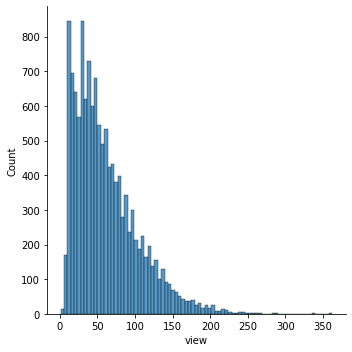

In [23]:
# Распределение просмотров в группе 1
print(df[df.exp_group == 1].view.mean())
sns.displot(df[df.exp_group == 1].view);

Распределение далеко от нормального, поэтому сравнение выборок пока возможно провести только непараметрическими методами. Но попробуем как-то поработать с ним.

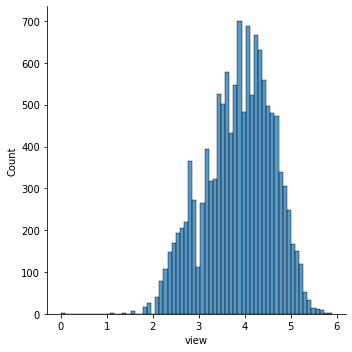

In [24]:
sns.displot(np.log(df[df.exp_group == 0].view));

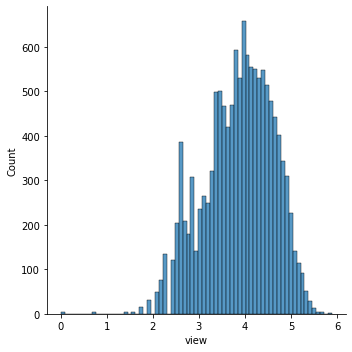

In [25]:
sns.displot(np.log(df[df.exp_group == 1].view));

Распределения в в обоих группах стали заметно больше походить на нормальные. Хотя и далеки от идеального, попробуем поработать с ними.

***Гипотеза:*** Выдвинем новую гипотезу, что в группе 1 в сравнении с группой 0 уменьшилось число просмотров \
***Нулевая гипотеза:*** число просмотров в экспериментальной группе равно или больше, нежели в контрольной группе \
***Альтернативная гипотеза:*** число просмотров в экспериментальной группе меньше, чем в контрольной. \
***Пороговое значение p-value:*** 0.05

In [26]:
# Сравнение непараметричиским U-критерием Манна — Уитни
stats.mannwhitneyu(np.log(df[df.exp_group == 0].view), np.log(df[df.exp_group == 1].view), alternative = 'greater')

MannwhitneyuResult(statistic=84514942.0, pvalue=0.48586381818421304)

In [27]:
# Сравнение параметричиским T-тестом
stats.ttest_ind(np.log(df[df.exp_group == 0].view), np.log(df[df.exp_group == 1].view), equal_var = False, alternative = 'greater')

Ttest_indResult(statistic=0.21340400193402262, pvalue=0.4155067663875661)

Результаты сравнения количества просмотров в группах 0 и 1 критерием Манна-Уитни и t-тестом, со соответствующими значениями p-value 0.48 и 0.41, превышающими пороговое значение 0.05, не позволяют отменить нулевую гипотезу. \
**Вывод:** новый алгоритм не привел к снижению количества просмотров в экспериментальной группе.

**Задача 3. Написать рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей.**

### ВЫВОД
По результатам A/B теста, проходившего с 2022-01-28 по 2022-02-03 включительно на группах 0 и 1, был получен статистически значимый результат: увеличение количества CTR в экспериментальной группе, при неизменившемся количестве просмотров в контрольной. Рекоменую раскатать новый алгоритм в проде на всех пользователей.